In [26]:
#Base
import numpy as np
import pandas as pd
import scipy.spatial
import dataclasses
import os, sys, time
import json
import itertools

#Plot 
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
default_figsize = [5, 5]
plt.rcParams['figure.figsize'] = default_figsize
color_names=['amber','red','windows blue','faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)

# EM-coregistration Github
# https://github.com/RussTorres/em_coregistration/tree/rmt_working_branch
sys.path.append('/home/david.wyrick/Git/em_coregistration/')
import coregister
import coregister.transform
import coregister.data_loader
from coregister.process.affine_matrices import transform_pts
from coregister.process.roi import center_from_pix_mask
from coregister.io.read_nwb import ROI_mask_nwb

#Cave
import requests
from requests.auth import HTTPBasicAuth
import caveclient

#V1DD
from allen_v1dd.client import OPhysClient, EMClient
em_client = EMClient()

%matplotlib inline
%load_ext autoreload
%autoreload 2

PlotDir = '/home/david.wyrick/projects/V1DD/coregistration/plots'

/home/david.wyrick/anaconda3/envs/v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:21: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
coreg_table = em_client.get_coregistration_table()
coreg_table.head()


,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,score,...,pt_root_id,pt_position,bb_start_position,bb_end_position,roi,position_microns,axon_proofreading_status,axon_proofreading_complete,dendrite_proofreading_status,dendrite_proofreading_complete
0,1,2023-02-14 16:50:14.491563+00:00,t,277703,1,3,14,2,NaN,NaN,...,864691132710145793,"[794469, 608850, 265500]","[789813, 605047, 28149]","[799901, 612885, 29027]",M409828_13_3_14,"[-112.56958689132821, 379.9149376229234, -318....",submitted,True,not_started,False
1,2,2023-02-14 16:50:14.492369+00:00,t,277515,1,3,60,0,NaN,NaN,...,864691132760377194,"[834898, 578974, 258390]","[829699, 575016, 27320]","[840253, 582931, 28368]",M409828_13_1_60,"[-72.29384663421894, 349.02511979865596, -317....",submitted,True,not_started,False
2,3,2023-02-14 16:50:14.493215+00:00,t,277213,1,3,30,1,NaN,NaN,...,864691132720617684,"[786864, 593718, 243945]","[782441, 588906, 25792]","[791287, 598451, 26699]",M409828_13_2_30,"[-120.27578675795336, 359.60326492832394, -335...",submitted,True,not_started,False
3,4,2023-02-14 16:50:14.494034+00:00,t,293528,1,3,119,4,NaN,NaN,...,864691132741334425,"[759859, 632673, 243810]","[755436, 627939, 25734]","[764515, 637174, 26753]",M409828_13_5_119,"[-147.09380413596915, 397.23444805560274, -345...",submitted,True,submitted,True
4,5,2023-02-14 16:50:14.494820+00:00,t,277969,1,3,271,1,NaN,NaN,...,864691132771662867,"[812705, 597132, 270405]","[808514, 592554, 28683]","[817050, 601866, 29619]",M409828_13_2_271,"[-94.38347656930343, 369.84693808481364, -310....",submitted,True,not_started,False


In [110]:
y1 = np.stack(coreg_table['pt_position'][indy])


In [111]:
y2 = test_set_em_final_pts_nms[indy3]

In [113]:
y1 - y2

array([[7., 0., 0.],
       [5., 0., 0.],
       [0., 2., 0.],
       [5., 5., 0.],
       [3., 6., 0.],
       [3., 7., 0.],
       [4., 0., 0.],
       [3., 3., 0.],
       [7., 1., 0.],
       [2., 3., 0.],
       [6., 7., 0.],
       [1., 8., 0.],
       [2., 8., 0.],
       [8., 6., 0.],
       [4., 2., 0.],
       [6., 1., 0.],
       [0., 2., 0.],
       [4., 0., 0.],
       [4., 0., 0.]])

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.suptitle('Co-registration of 22 test cells in em-space')
axes_labels = ['x','y','z']; lims = [[650,1050],[550,700],[150,350]]
for ii, xy in enumerate(itertools.combinations(np.arange(3),2)):
    _xaxis, _yaxis = xy
    ax = axes[ii]
    sns.scatterplot(x=corr_pts_em_nm[:, _xaxis]/scalar, y=corr_pts_em_nm[:, _yaxis]/scalar, marker='.',s=70, ax=ax,label='Co-registered cells used for creating transform')
    sns.scatterplot(x=test_set_em_final_pts_nms[:, _xaxis]/scalar, y=test_set_em_final_pts_nms[:, _yaxis]/scalar, marker='.',s=70, ax=ax,label='EM location of test set after transform')
    sns.scatterplot(x=test_centers_em_nm[:, _xaxis]/scalar, y=test_centers_em_nm[:, _yaxis]/scalar,marker= '+', s=70, ax=ax, color="r",label='True EM location of manually identified test set')

    sns.scatterplot(x=coreg_table_centers_em_nm[indy2, _xaxis]/scalar, y=coreg_table_centers_em_nm[indy2, _yaxis]/scalar,marker= '*', s=70, ax=ax,label='Co-registered table')

In [93]:
coreg_table.columns

Index(['id', 'created', 'valid', 'target_id', 'session', 'scan_idx', 'unit_id',
       'field', 'residual', 'score', 'id_ref', 'created_ref', 'valid_ref',
       'volume', 'pt_supervoxel_id', 'pt_root_id', 'pt_position',
       'bb_start_position', 'bb_end_position', 'roi', 'position_microns',
       'axon_proofreading_status', 'axon_proofreading_complete',
       'dendrite_proofreading_status', 'dendrite_proofreading_complete'],
      dtype='object')

In [53]:
def chaseROI_to_russelROI(roi_list):
    new_key_list = []
    for chase_key in roi_list:
        split = chase_key.split('_')
        pp = int(split[2])-1
        rr = int(split[3])

        russel_key = f'plane{pp}_roi_{rr:04d}'
        new_key_list.append(russel_key)
        print(f'{chase_key:20s} \t->\t',russel_key)
    return new_key_list
coreg_table_russelkeys = chaseROI_to_russelROI(coreg_table['roi'].values)
# coreg_table_russelkeys

M409828_13_3_14      	->	 plane2_roi_0014
M409828_13_1_60      	->	 plane0_roi_0060
M409828_13_2_30      	->	 plane1_roi_0030
M409828_13_5_119     	->	 plane4_roi_0119
M409828_13_2_271     	->	 plane1_roi_0271
M409828_13_3_269     	->	 plane2_roi_0269
M409828_13_2_262     	->	 plane1_roi_0262
M409828_13_3_158     	->	 plane2_roi_0158
M409828_13_3_230     	->	 plane2_roi_0230
M409828_13_1_278     	->	 plane0_roi_0278
M409828_13_1_88      	->	 plane0_roi_0088
M409828_13_2_75      	->	 plane1_roi_0075
M409828_13_4_14      	->	 plane3_roi_0014
M409828_13_2_5       	->	 plane1_roi_0005
M409828_13_3_83      	->	 plane2_roi_0083
M409828_13_3_25      	->	 plane2_roi_0025
M409828_13_3_74      	->	 plane2_roi_0074
M409828_13_1_65      	->	 plane0_roi_0065
M409828_13_4_89      	->	 plane3_roi_0089
M409828_13_3_191     	->	 plane2_roi_0191
M409828_13_5_109     	->	 plane4_roi_0109
M409828_13_1_40      	->	 plane0_roi_0040
M409828_13_4_187     	->	 plane3_roi_0187
M409828_13_1_117     	->	 plane0_r

In [5]:
# matrix that describes the transformation from the input functional space (in pixels) to the coregistration space (in microns) and its inverse
func_raw2coreg_tform_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/transforms/func_raw2coreg_tform.npy"
func_raw2coreg_tform = np.load(func_raw2coreg_tform_fn)
func_coreg2raw_tform = np.linalg.inv(func_raw2coreg_tform)

# matrix that describes the transformation from the input EM coregistration space (in microns) to the final EM space (in voxels)
em_coreg2final_tform_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/transforms/em_coreg2final_tform.npy"
em_coreg2final_tform = np.load(em_coreg2final_tform_fn)
em_final2coreg_tform = np.linalg.inv(em_coreg2final_tform)

In [6]:
# read in test coregistration set
test_set_name_to_final_em_nm_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/combined_noncp_name_to_final_em_nm.json"

with open(test_set_name_to_final_em_nm_fn) as f:
    test_set_name_to_final_em_nm = json.load(f)

test_set_name_to_final_em_nm

{'plane4_roi_0119': [759852.0, 632673.0, 243810.0],
 'plane1_roi_0271': [812700.0, 597132.0, 270405.0],
 'plane1_roi_0262': [918396.0, 607140.0, 236025.0],
 'plane0_roi_0088': [870822.0, 603801.0, 161595.0],
 'plane1_roi_0075': [843354.0, 608688.0, 227655.0],
 'plane3_roi_0089': [841491.0, 654471.0, 186975.0],
 'plane2_roi_0191': [833265.0, 610479.0, 225990.0],
 'plane4_roi_0109': [839862.0, 615132.0, 314550.0],
 'plane0_roi_0040': [782046.0, 575325.0, 261720.0],
 'plane3_roi_0187': [807426.0, 650673.0, 173430.0],
 'plane3_roi_0306': [813087.0, 603333.0, 323145.0],
 'plane2_roi_0215': [790821.0, 597357.0, 278415.0],
 'plane2_roi_0300': [859185.0, 596736.0, 276975.0],
 'plane2_roi_0294': [758070.0, 615213.0, 223065.0],
 'plane3_roi_0325': [758070.0, 615213.0, 223065.0],
 'plane5_roi_0470': [837684.0, 637866.0, 330660.0],
 'plane0_roi_0067': [897750.0, 583938.0, 257715.0],
 'plane2_roi_0032': [815337.0, 626697.0, 172485.0],
 'plane2_roi_0250': [835209.0, 593172.0, 319005.0],
 'plane0_roi

In [65]:
#How many of these 55 cells from the co-registration table are in the test set?
indy = []
for ii, k in enumerate(coreg_table_russelkeys):
    if k in test_set_name_to_final_em_nm.keys():
        indy.append(ii)
print(len(indy))

19


## build coregistration transform

In [7]:
# get landmarks from file used as input
landmark_file = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/manual_coregistration/20230317_V1_C3_V1DD/landmarks_EM_to_2pStruct+Funct3chan_vol_13_202303017_V5.csv"
landmark_headers = ['label', 'flag', 'emx', 'emy', 'emz', 'optx', 'opty', 'optz']

coreg_df = pd.read_csv(
    landmark_file,
    header=None,
    names=landmark_headers
)

valid_coreg_df = coreg_df[coreg_df.flag]

em_coreg_pts = np.array(valid_coreg_df[["emx", "emy", "emz"]])
func_coreg_pts = np.array(valid_coreg_df[["optx", "opty", "optz"]])


In [9]:
#This table does not have roi IDs. Russell confirmed that we don't know identity of cells
valid_coreg_df

,label,flag,emx,emy,emz,optx,opty,optz
0,Pt-0,True,635.280344,328.978703,226.841928,119.337257,469.505399,75.311303
1,Pt-1,True,698.750236,322.681404,275.377240,163.517246,516.582437,75.009528
2,Pt-2,True,708.255653,330.192179,355.508033,176.817332,600.794368,93.116080
3,Pt-3,True,903.305203,379.623403,346.601671,381.113136,563.926411,130.782925
4,Pt-4,True,637.073622,448.602289,212.665276,140.822510,434.169473,181.844683
...,...,...,...,...,...,...,...,...
166,Pt-167,True,657.726865,541.792011,389.449195,141.067111,600.960586,327.332998
167,Pt-168,True,664.090085,534.638135,409.200705,146.879157,621.033032,326.281045
168,Pt-169,True,637.441519,526.550801,423.039181,117.657481,636.143693,323.096453
169,Pt-170,True,675.456796,522.787312,423.113680,161.177480,633.418759,318.343023


In [8]:
## Q: Are all of these transformations being fit and applied successively? I think so
transform_list = [
    {
        "name": "PolynomialModel",
        "order": 1,
        "regularization": [0, 0, 0, 0]
    },
    # {
    #     "name": "ChunkedModel",
    #     "order": 1,
    #     "nchunks": 3,
    #     "axis": 1
    # },
    # {
    #     "name": "ChunkedModel",
    #     "order": 1,
    #     "nchunks": 3,
    #     "axis": 2
    # },
    {
        "name": "ChunkedModel",
        "order": 1,
        "nchunks": 3,
        "axis": 0
    },
    {
        "name": "SplineModel",
        "ncntrl": [3, 3, 3],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [5, 5, 5],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e8]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6] # originally last was 1e8
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e9]
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]  # originally last was 1e9
    },
    # {
    #     "name": "SplineModel",
    #     "voronoi_cntrl": True,
    #     "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e9]
    # },
    # {
    #     "name": "SplineModel",
    #     "voronoi_cntrl": True,
    #     "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e8]
    # },
    {
        "name": "SplineModel",
        "voronoi_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    # {
    #     "name": "SplineModel",
    #     "voronoi_cntrl": True,
    #     "regularization": [1e-7, 1e-7, 1e-7, 1e-7, 1e4]
    # },
    # {
    #     "name": "SplineModel",
    #     "voronoi_cntrl": True,
    #     "regularization": [1e-7, 1e-7, 1e-7, 1e-7, 5e3]
    # },
    # {
    #     "name": "SplineModel",
    #     "voronoi_cntrl": True,
    #     "regularization": [1e-7, 1e-7, 1e-7, 1e-7, 1e3]
    # },
    # FIXME below this is included in v1!!!!!
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]
    },
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 5e4]
    },
    # {
    #     "name": "SplineModel",
    #     "src_is_cntrl": True,
    #     "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 5e2]
    # }
        
]

transform_obj = {
        "name": "TransformList",
        "transforms": transform_list
    }

In [9]:
# estimate transformation
tform = coregister.transform.Transform(json=transform_obj)
tform.estimate(func_coreg_pts, em_coreg_pts)

## evaluate transformation

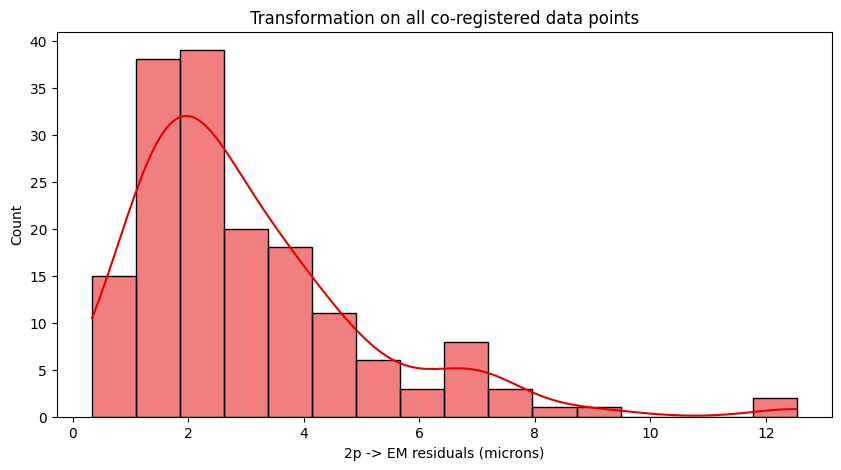

In [10]:
fit_residuals = np.linalg.norm(tform.tform(func_coreg_pts)-em_coreg_pts, axis=1)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Transformation on all co-registered data points')
sns.histplot(fit_residuals,ax=ax,kde=True,color=cc[1])
ax.set_xlabel('2p -> EM residuals (microns)')
plt.savefig(os.path.join(PlotDir,'residuals_fitonall.png'))

In [11]:
# evaluate l1out residual for all points
# TODO make helper method in coregister

# build leave-one-out dataset
@dataclasses.dataclass
class L1OutResult:
    src_pt : np.ndarray
    dst_pt : np.ndarray
    predicted_dst : np.ndarray
    pt_idx : str


l1out_transform_obj = {
        "name": "TransformList",
        "transforms": transform_list[:]
    }

src_vol_label = "opt"
dst_vol_label = "em"
l1out_src_pts = func_coreg_pts[:]
l1out_dst_pts = em_coreg_pts[:]


In [12]:
results = []
mean_residuals = []

#Loop over each cell and calculate tranform without it
for idx in range(l1out_src_pts.shape[0]):
    pts_mask = np.zeros(l1out_src_pts.shape[0], dtype=bool)
    pts_mask[idx] = True
    
    masked_src_pts = l1out_src_pts[~pts_mask]
    masked_dst_pts = l1out_dst_pts[~pts_mask]
    
    l1out_tform = coregister.transform.Transform(json=l1out_transform_obj)
    l1out_tform.estimate(masked_src_pts, masked_dst_pts)
    
    mean_residuals.append(np.linalg.norm(tform.tform(masked_src_pts) - masked_dst_pts, axis=1).mean())
    
    
    lno_src_pts = np.array([l1out_src_pts[idx]])
    lno_dst_pts = np.array([l1out_dst_pts[idx]])
    
    predicted_dsts = l1out_tform.tform(lno_src_pts)
    
    results.append(L1OutResult(
        src_pt=lno_src_pts[0], 
        dst_pt=lno_dst_pts[0],
        predicted_dst=predicted_dsts[0],
        pt_idx=idx
    ))



In [13]:
l1out_disps = np.array([r.dst_pt - r.predicted_dst for r in results])
l1out_residuals = np.linalg.norm(l1out_disps, axis=1)

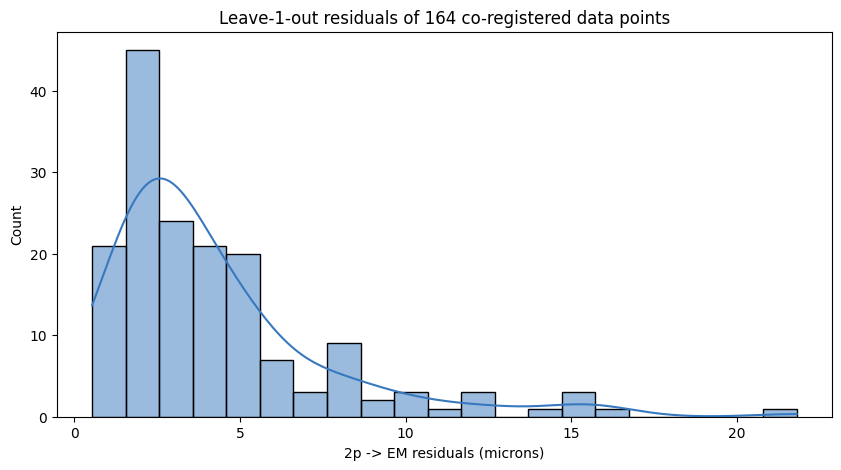

In [14]:


fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Leave-1-out residuals of 164 co-registered data points')
sns.histplot(l1out_residuals,ax=ax,kde=True,color=cc[2])
ax.set_xlabel('2p -> EM residuals (microns)')
plt.savefig(os.path.join(PlotDir,'residuals_L1O.png'))


# fig, ax = plt.subplots(figsize=(10,5))
# ax.set_title('Residiual comparison')
# sns.histplot(fit_residuals,ax=ax,kde=True,color=cc[1],label='all')
# sns.histplot(l1out_residuals,ax=ax,kde=True,color=cc[2],label='L1O')
# ax.set_xlabel('2p -> EM residuals (microns)')
# ax.legend()
# plt.savefig(os.path.join(PlotDir,'residuals_compare.png'))


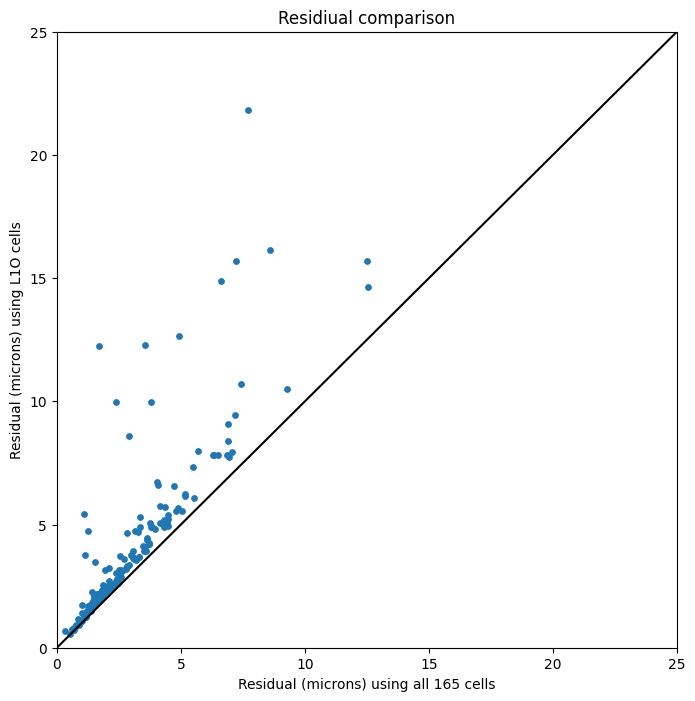

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Residiual comparison')

ax.plot([0,25],[0,25],'-k')
ax.scatter(fit_residuals,l1out_residuals,s=15)

ax.set_xlabel('Residual (microns) using all 165 cells')
ax.set_ylabel('Residual (microns) using L1O cells')

ax.set_xlim([0,25]);ax.set_ylim([0,25])
plt.savefig(os.path.join(PlotDir,'residuals_compare.png'))

## apply transformation

In [33]:
em_final_voxel_size = np.array([4.85, 4.85, 45])

#Get 2p functional data for column 1 volumn 3
nwb_file = '/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data/nwbs/processed/M409828_13_20181213.nwb'
with ROI_mask_nwb(nwb_file, mode="r") as rmn:
    # import pdb; pdb.set_trace()
    all_roi_info = [*rmn.yield_roi_info()]

In [34]:
all_roi_info[0]

FunctionalRoiInfo(plane_name='plane0', roi_name='roi_0000', plane_z=0, pix_mask=array([[359, 357, 358, 359, 360, 361, 362, 355, 356, 357, 358, 359, 360,
        361, 362, 363, 364, 354, 355, 356, 357, 358, 359, 360, 361, 362,
        363, 364, 365, 366, 367, 353, 354, 355, 356, 357, 358, 359, 360,
        361, 362, 363, 364, 365, 366, 367, 368, 353, 354, 355, 356, 357,
        358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 353, 354,
        355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367,
        368, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
        365, 366, 367, 368, 352, 353, 354, 355, 356, 357, 358, 359, 360,
        361, 362, 363, 364, 365, 366, 367, 352, 353, 354, 355, 356, 357,
        358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 352, 353, 354,
        355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 352,
        353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365,
        366, 352, 353, 354, 355, 356, 357, 3

In [35]:
# Get 2p ROI center of mass 
all_roi_raw_center_pts = np.array([center_from_pix_mask(roi.pix_mask).tolist() + [roi.plane_z] for roi in all_roi_info])

# Get names
all_roi_names = np.array([roi.name for roi in all_roi_info])

#Get pika scores
pika_threshold = 0.5
all_pika_scores = np.array([roi.pika_score for roi in all_roi_info])
all_valid_cells = all_pika_scores > pika_threshold

# Transform raw 2p coordinates into co-registration space (micron space)
all_roi_func_coreg_pts = transform_pts(func_raw2coreg_tform, all_roi_raw_center_pts)

#Transform 2p functional locations to EM using transform created using all co-registered cells
all_roi_em_coreg_pts = tform.tform(all_roi_func_coreg_pts)

# Transform coregistered points back into EM space 
all_roi_em_final_pts_voxels = transform_pts(em_coreg2final_tform, all_roi_em_coreg_pts)
all_roi_em_final_pts_nms = all_roi_em_final_pts_voxels * em_final_voxel_size

In [43]:
np.unique(np.array([roi.plane_z for roi in all_roi_info]),return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([1234, 1222, 1482, 1279, 1158, 1148]))

In [59]:
# Get co-registered test set
test_set_names = np.array([*test_set_name_to_final_em_nm.keys()])
test_set_em_final_pts_nms = np.array([*test_set_name_to_final_em_nm.values()])


In [38]:
# TODO implement this as a utility

def get_array_subset_indices(set_arr, subset_arr):
    set_arr_sorted = np.argsort(set_arr)
    subset_arr_pos = np.searchsorted(set_arr[set_arr_sorted], subset_arr)
    indices = set_arr_sorted[subset_arr_pos]
    return indices

In [58]:
#Get transformed points in em space of cells from cave client coregistration table 
coreg_table_idxs = get_array_subset_indices(all_roi_names, coreg_table_russelkeys)
coreg_table_centers_em_nm = all_roi_em_final_pts_nms[coreg_table_idxs]


In [61]:
#Get test set indices
test_set_idxs = get_array_subset_indices(all_roi_names, test_set_names)

#Transform test points from coregistration space to raw pixel space
test_centers_func_raw = all_roi_raw_center_pts[test_set_idxs]
corr_pts_func_raw = transform_pts(func_coreg2raw_tform, func_coreg_pts)

#Grab test set in em space
test_centers_em_nm = all_roi_em_final_pts_nms[test_set_idxs]

#Transform points used for creating transform into em space
corr_pts_em_voxels = transform_pts(em_coreg2final_tform, em_coreg_pts)
corr_pts_em_nm = corr_pts_em_voxels * em_final_voxel_size

#Get residuals on test cells
disps = test_centers_em_nm - test_set_em_final_pts_nms
test_set_residuals = np.linalg.norm(disps, axis=1)
print(np.mean(np.abs(disps), axis=0)/1000, 'microns')

[2.51490292 4.57940053 1.60805223] microns


In [104]:
indy = []; indy2 = []; indy3 = []
for ii, k in enumerate(coreg_table_russelkeys):
    if k in test_set_name_to_final_em_nm.keys():
        indy.append(ii)
        indy3.append([jj for jj, roi in enumerate(test_set_name_to_final_em_nm.keys()) if k == roi][0])
    else:
        indy2.append(ii)
print(len(indy))


19


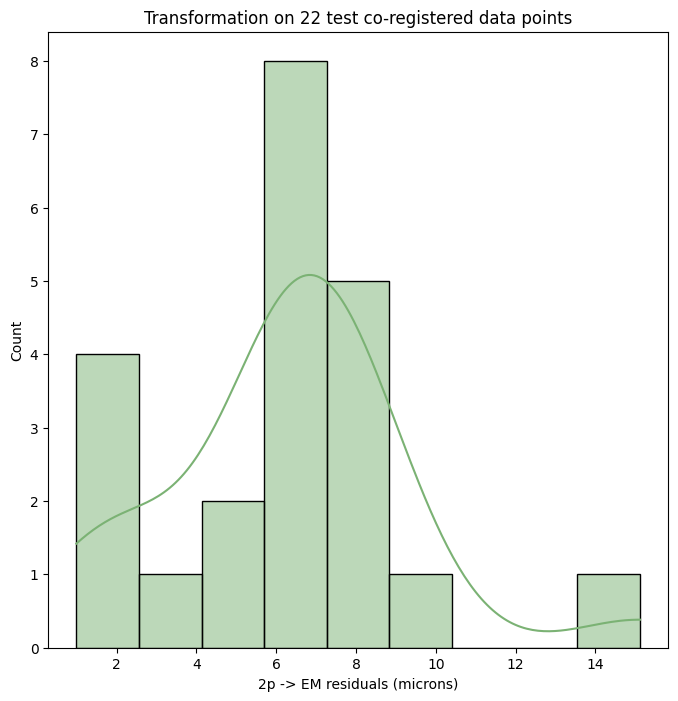

In [62]:

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Transformation on 22 test co-registered data points')
sns.histplot(test_set_residuals/1000,ax=ax,kde=True,color=cc[3])
ax.set_xlabel('2p -> EM residuals (microns)')
plt.savefig(os.path.join(PlotDir,'residuals_test.png'))

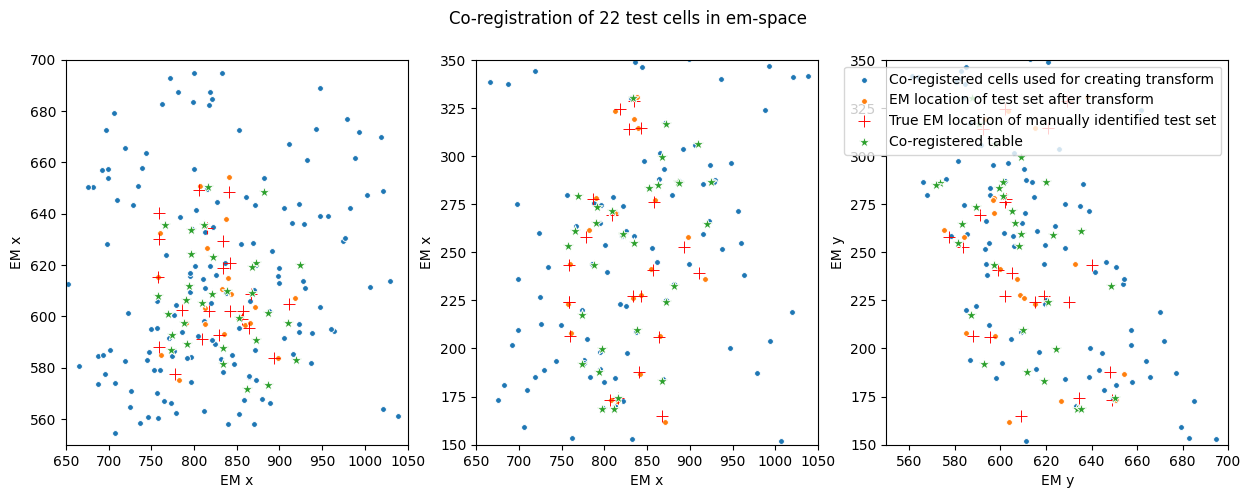

In [92]:

scalar = 1000
ax_sizes = (512, 512, 6)

fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.suptitle('Co-registration of 22 test cells in em-space')
axes_labels = ['x','y','z']; lims = [[650,1050],[550,700],[150,350]]
for ii, xy in enumerate(itertools.combinations(np.arange(3),2)):
    _xaxis, _yaxis = xy
    ax = axes[ii]
    sns.scatterplot(x=corr_pts_em_nm[:, _xaxis]/scalar, y=corr_pts_em_nm[:, _yaxis]/scalar, marker='.',s=70, ax=ax,label='Co-registered cells used for creating transform')
    sns.scatterplot(x=test_set_em_final_pts_nms[:, _xaxis]/scalar, y=test_set_em_final_pts_nms[:, _yaxis]/scalar, marker='.',s=70, ax=ax,label='EM location of test set after transform')
    sns.scatterplot(x=test_centers_em_nm[:, _xaxis]/scalar, y=test_centers_em_nm[:, _yaxis]/scalar,marker= '+', s=70, ax=ax, color="r",label='True EM location of manually identified test set')

    sns.scatterplot(x=coreg_table_centers_em_nm[indy2, _xaxis]/scalar, y=coreg_table_centers_em_nm[indy2, _yaxis]/scalar,marker= '*', s=70, ax=ax,label='Co-registered table')

    if ii < 2:
        ax.get_legend().remove()
    ax.set_xlim(lims[_xaxis])
    ax.set_ylim(lims[_yaxis])
    ax.set_xlabel(f'EM {axes_labels[_xaxis]}')
    ax.set_ylabel(f'EM {axes_labels[_xaxis]}')
    
plt.savefig(os.path.join(PlotDir,'EM_location_predvtrue.pdf'))

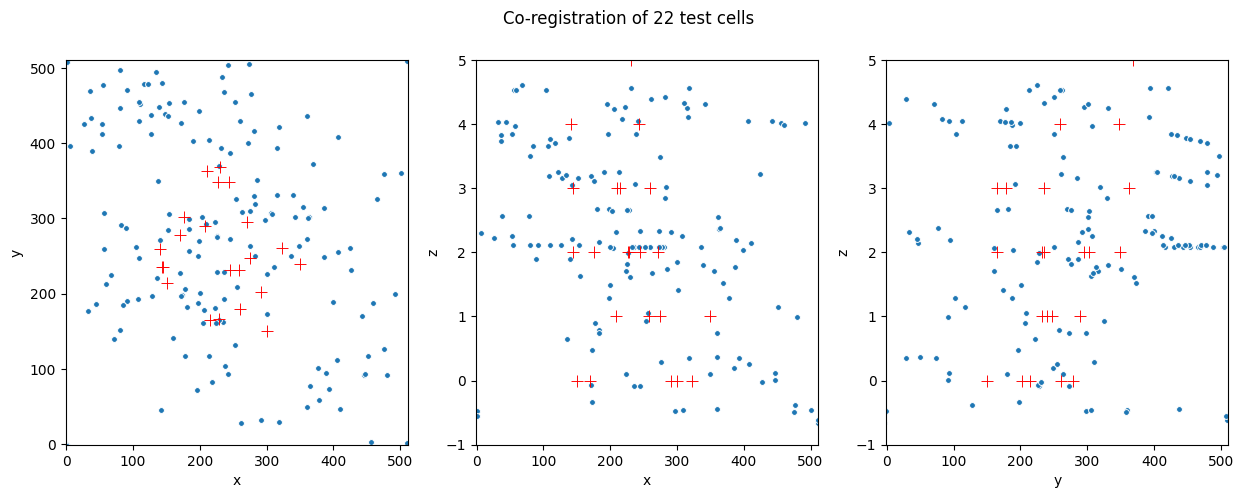

In [21]:


ax_sizes = (512, 512, 6)

fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.suptitle('Co-registration of 22 test cells')
axes_labels = ['x','y','z']
for ii, xy in enumerate(itertools.combinations(np.arange(3),2)):
    _xaxis, _yaxis = xy
    ax = axes[ii]
    sns.scatterplot(x=corr_pts_func_raw[:, _xaxis], y=corr_pts_func_raw[:, _yaxis], marker='.',s=70, ax=ax,label='Set used for calculating transform')
    sns.scatterplot(x=test_centers_func_raw[:, _xaxis], y=test_centers_func_raw[:, _yaxis],marker= '+', s=70, ax=ax, color="r",label='Test set')


    ax.set_xlim(-1, ax_sizes[_xaxis] - 1)
    ax.set_ylim(-1, ax_sizes[_yaxis] - 1)
    ax.set_xlabel(axes_labels[_xaxis])
    ax.set_ylabel(axes_labels[_yaxis])


(0.0, 5.0)

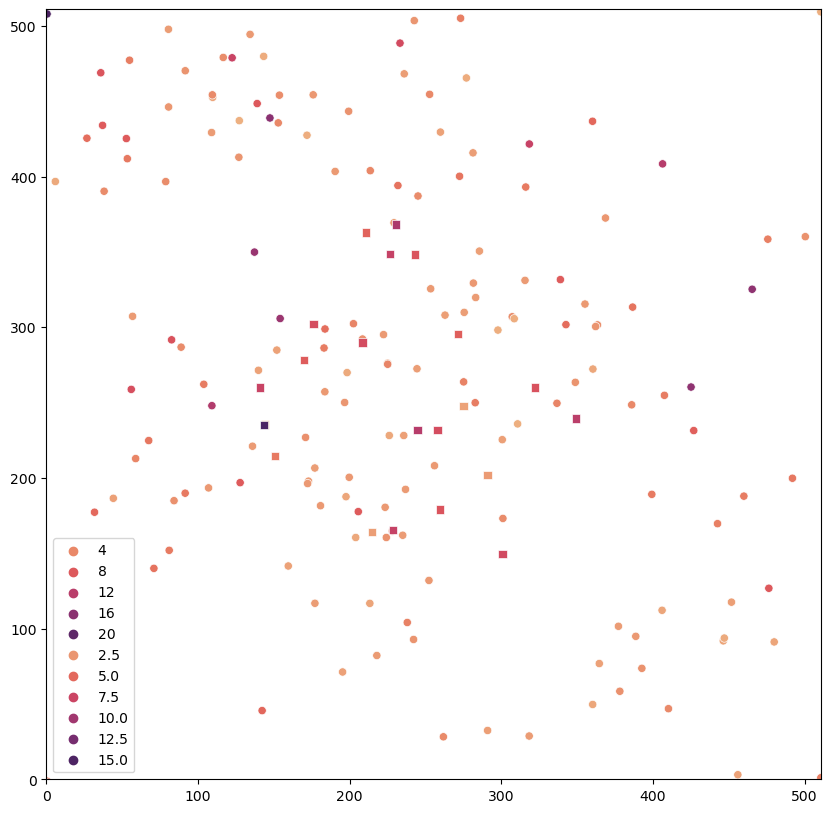

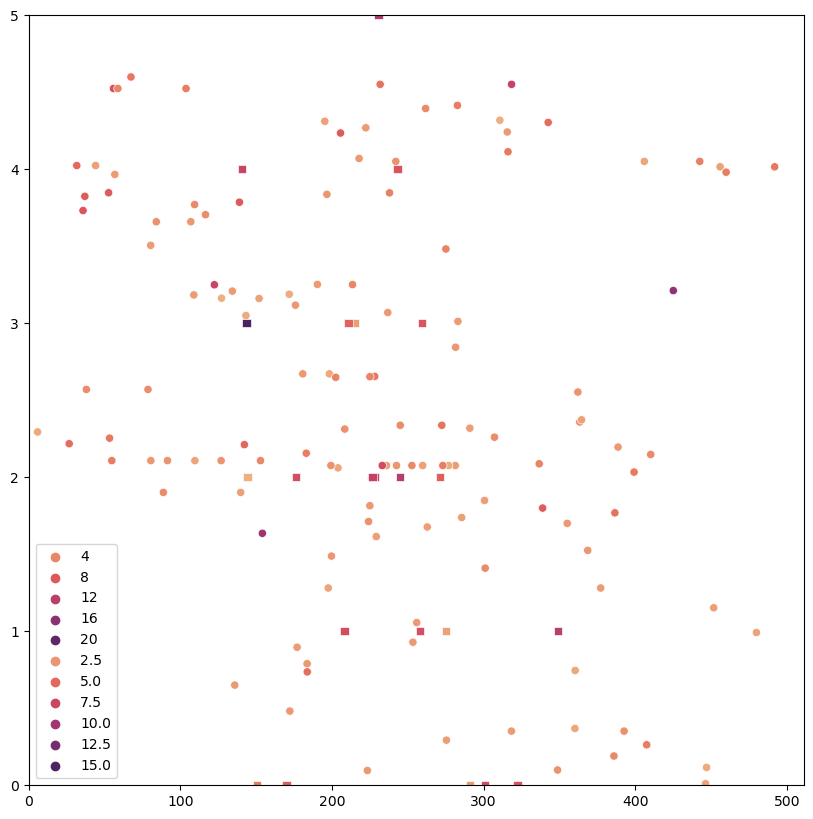

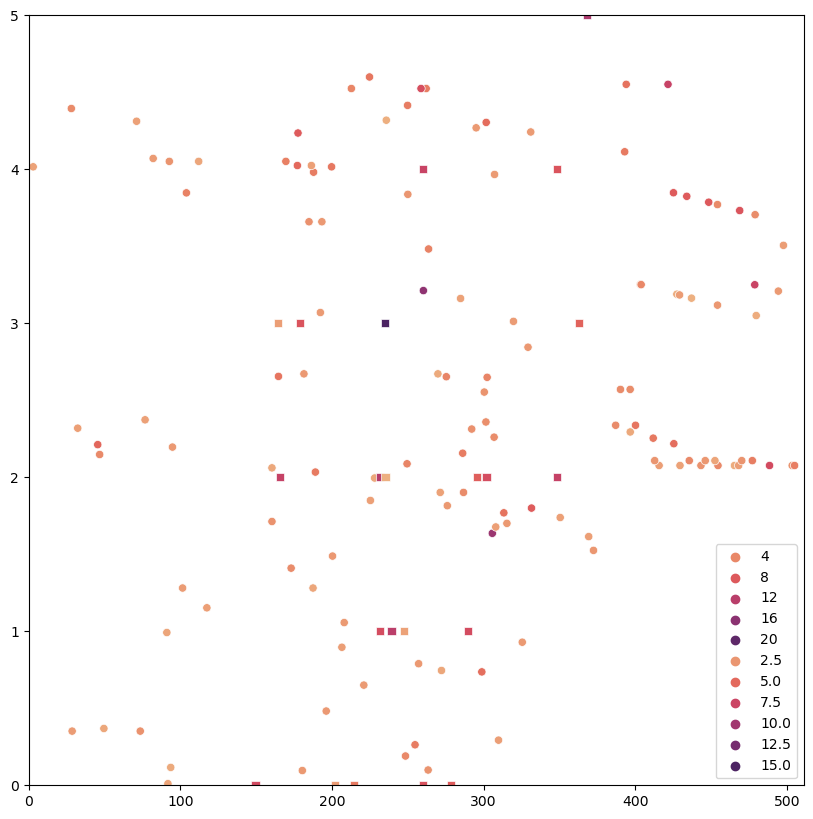

In [483]:
# TODO share colorbar
# TODO look in 3d

# plot residuals
def get_sm(arr, *args, **kwargs):
    norm = plt.Normalize(arr.min(), arr.max())
    sm = plt.cm.ScalarMappable(*args, norm=norm, **kwargs)
    sm.set_array([])
    return sm

test_set_residuals_um = test_set_residuals / 1000

l1out_cmap = seaborn.color_palette("flare", as_cmap=True)
test_set_cmap = seaborn.color_palette("flare", as_cmap=True)

# TODO put these on the same scale
l1out_sm = get_sm(l1out_residuals, cmap=l1out_cmap)
test_set_sm = get_sm(test_set_residuals_um, cmap=test_set_cmap)


ax_sizes = (512, 512, 6)

fig, ax_xy = plt.subplots()
_xaxis, _yaxis = 0, 1
ax_xy = seaborn.scatterplot(x=corr_pts_func_raw[:, _xaxis], y=corr_pts_func_raw[:, _yaxis], hue=l1out_residuals, palette=l1out_cmap, ax=ax_xy)
ax_xy = seaborn.scatterplot(x=test_centers_func_raw[:, _xaxis], y=test_centers_func_raw[:, _yaxis], hue=test_set_residuals_um, palette=test_set_cmap, ax=ax_xy, marker="s")
ax_xy.set_xlim(0, ax_sizes[_xaxis] - 1)
ax_xy.set_ylim(0, ax_sizes[_yaxis] - 1)


fig, ax_xz = plt.subplots()
_xaxis, _yaxis = 0, 2
ax_xz = seaborn.scatterplot(x=corr_pts_func_raw[:, _xaxis], y=corr_pts_func_raw[:, _yaxis], hue=l1out_residuals, palette=l1out_cmap, ax=ax_xz)
ax_xz = seaborn.scatterplot(x=test_centers_func_raw[:, _xaxis], y=test_centers_func_raw[:, _yaxis], hue=test_set_residuals_um, palette=test_set_cmap, ax=ax_xz, marker="s")
ax_xz.set_xlim(0, ax_sizes[_xaxis] - 1)
ax_xz.set_ylim(0, ax_sizes[_yaxis] - 1)


fig, ax_yz = plt.subplots()
_xaxis, _yaxis = 1, 2
ax_yz = seaborn.scatterplot(x=corr_pts_func_raw[:, _xaxis], y=corr_pts_func_raw[:, _yaxis], hue=l1out_residuals, palette=l1out_cmap, ax=ax_yz)
ax_yz = seaborn.scatterplot(x=test_centers_func_raw[:, _xaxis], y=test_centers_func_raw[:, _yaxis], hue=test_set_residuals_um, palette=test_set_cmap, ax=ax_yz, marker="s")
ax_yz.set_xlim(0, ax_sizes[_xaxis] - 1)
ax_yz.set_ylim(0, ax_sizes[_yaxis] - 1)

# ax_yz.figure.colorbar(test_set_sm)
# ax_yz.figure.colorbar(l1out_sm)

## correspondence to EM

In [9]:
client = caveclient.CAVEclient('v1dd')

# read EM nucleus table
cave_client = caveclient.CAVEclient(
    datastack_name="v1dd",
    server_address="https://global.em.brain.allentech.org",
    auth_token=cave_tkn)



HTTPError: 401 Client Error: UNAUTHORIZED for url: https://global.em.brain.allentech.org/info/api/v2/datastack/full/v1dd content: b'{\n  "error": "invalid_token", \n  "message": "Unauthorized - Token is Invalid or Expired"\n}\n'

In [431]:
# define bounding box for table query


min_nm = all_roi_em_final_pts_nms.min(axis=0)
max_nm = all_roi_em_final_pts_nms.max(axis=0)

# 40 um buffer around area
buffer_um = 40
k = 1000
buffer_nm = buffer_um * k
buffer = numpy.array((buffer_nm, buffer_nm, buffer_nm))

query_bbox = numpy.array([
    min_nm - buffer,
    max_nm + buffer
])

In [432]:
res = cave_client.materialize.query_table(
    "nucleus_detection_v0",
    filter_spatial_dict={"pt_position": query_bbox})


In [433]:
nucleus_pts = numpy.array([i for i in res.pt_position])
nucleus_ids = numpy.array([i for i in res.pt_root_id])
print(nucleus_pts.shape)

(21515, 3)


In [434]:
# match using simple euclidean distance
kdt = scipy.spatial.kdtree.KDTree(nucleus_pts)

distances, indices = kdt.query(all_roi_em_final_pts_nms, k=2)
rod = distances[:, 0] / distances[:, 1]
eu_predicted_nucleus_pts_centroids = nucleus_pts[indices[:, 0]]

In [435]:
# match using 2d refinement
refinement_cutoff_nm = 6000
refinement_cutoff_rod = 0.75
k=2
axes_2d = [0, 2]

kdt = scipy.spatial.kdtree.KDTree(nucleus_pts)
distances, indices = kdt.query(all_roi_em_final_pts_nms, k=k)
rod = distances[:, 0] / distances[:, 1]
refine_mask = (distances[:, 0] >= refinement_cutoff_nm) & (rod >= refinement_cutoff_rod)

predicted_nucleus_pts_centroids = nucleus_pts[indices[:, 0]]

for idx in numpy.argwhere(refine_mask):
    kdt_2d = scipy.spatial.kdtree.KDTree(nucleus_pts[indices[idx]][0, :, axes_2d].T)
    dists_2d, idxs_2d = kdt_2d.query([all_roi_em_final_pts_nms[idx, axes_2d]])
    nucleus_idx = indices[idx][0][idxs_2d[0]]
    predicted_nucleus_pts_centroids[idx] = nucleus_pts[nucleus_idx]

In [ ]:
# TODO match using 3d weights

[1095.71090199 1958.8088956   776.60056374]


<AxesSubplot:ylabel='Count'>

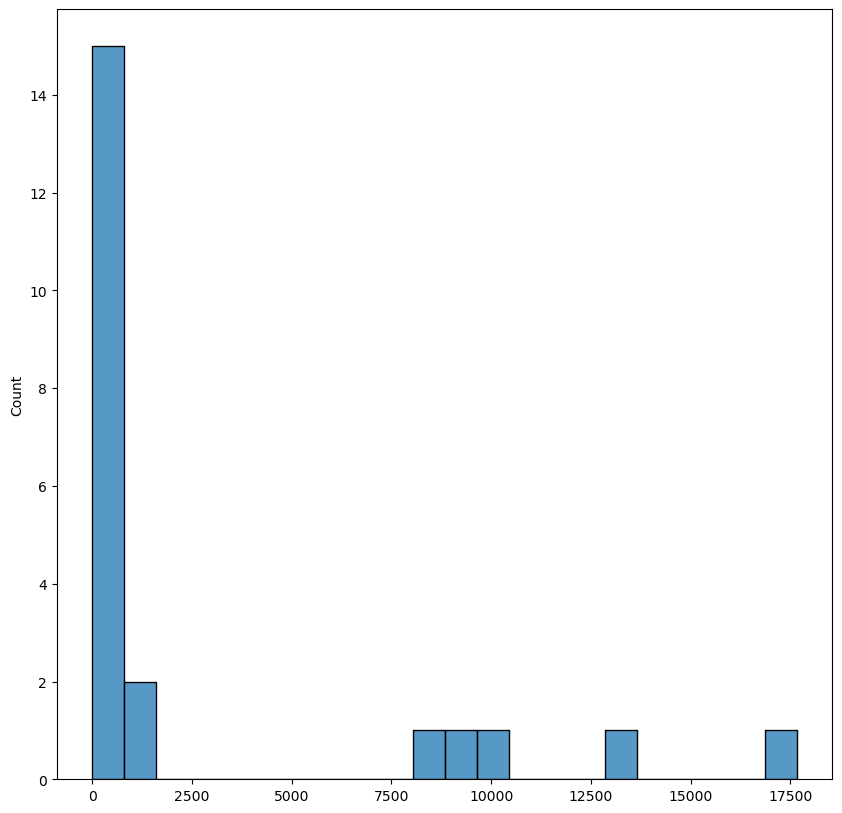

In [436]:
# compare to test set
pre_snap_test_disps = all_roi_em_final_pts_nms[test_set_idxs] - test_set_em_final_pts_nms
pre_snap_test_dists = numpy.linalg.norm(pre_snap_test_disps, axis=1)


post_snap_test_disps = predicted_nucleus_pts_centroids[test_set_idxs] - test_set_em_final_pts_nms
post_snap_test_dists = numpy.linalg.norm(post_snap_test_disps, axis=1)
print(numpy.mean(numpy.abs(post_snap_test_disps), axis=0))
seaborn.histplot(post_snap_test_dists)

(0.0, 17758.595300872603)

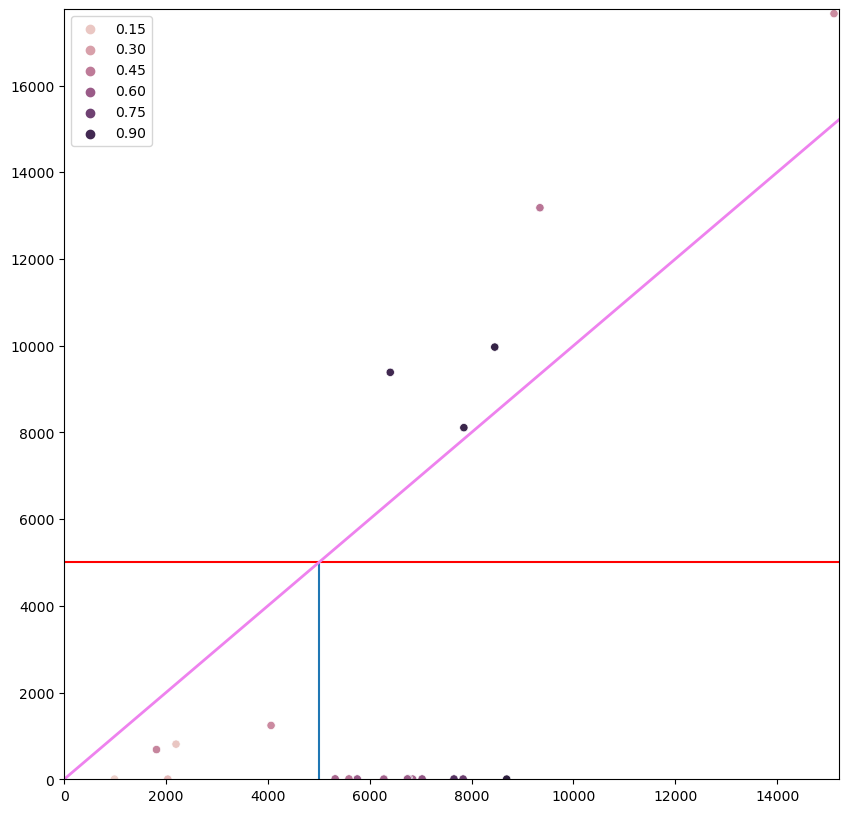

In [437]:
ax = seaborn.scatterplot(x=pre_snap_test_dists, y=post_snap_test_dists, hue=rod[test_set_idxs])

xmax = pre_snap_test_dists.max()+100
ymax = post_snap_test_dists.max()+100

xplot = numpy.linspace(0, xmax, 1000)
ax.vlines([5000], ymin=0, ymax=5000)
ax.hlines([5000], xmin=0, xmax=xmax, colors=["r"])
plt.plot(xplot, xplot, linewidth=2, c="violet")
ax.set_xlim(0, xmax)
ax.set_ylim(0, ymax)


In [487]:
agreement_thres = 4000
disagreement_mask = (post_snap_test_dists >= agreement_thres)
print(disagreement_mask.sum(), len(post_snap_test_dists))
print((~disagreement_mask).sum() / len(post_snap_test_dists))

rod[test_set_idxs][disagreement_mask]

5 22
0.7727272727272727


array([0.9416961 , 0.37907754, 0.47947691, 0.90363732, 0.91974878])

In [439]:
test_set_names[disagreement_mask]

array(['plane1_roi_0262', 'plane3_roi_0325', 'plane5_roi_0470',
       'plane0_roi_0067', 'plane2_roi_0250'], dtype='<U15')

In [440]:
rod[test_set_idxs][~disagreement_mask]

array([0.82906308, 0.5578564 , 0.63755864, 0.71851105, 0.51466032,
       0.97371675, 0.57158554, 0.6071571 , 0.20711609, 0.5474772 ,
       0.59909227, 0.49219014, 0.10796504, 0.76734299, 0.38430558,
       0.1541723 , 0.40641703])

In [441]:
disagreement_points = test_set_em_final_pts_nms[disagreement_mask]

In [442]:
# visualize what "snapping" to EM nuclei does in planes

snap_residuals = predicted_nucleus_pts_centroids - all_roi_em_final_pts_nms

In [443]:
snap_dists = numpy.linalg.norm(snap_residuals, axis=1)

norm = plt.Normalize(snap_dists.min(), snap_dists.max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])



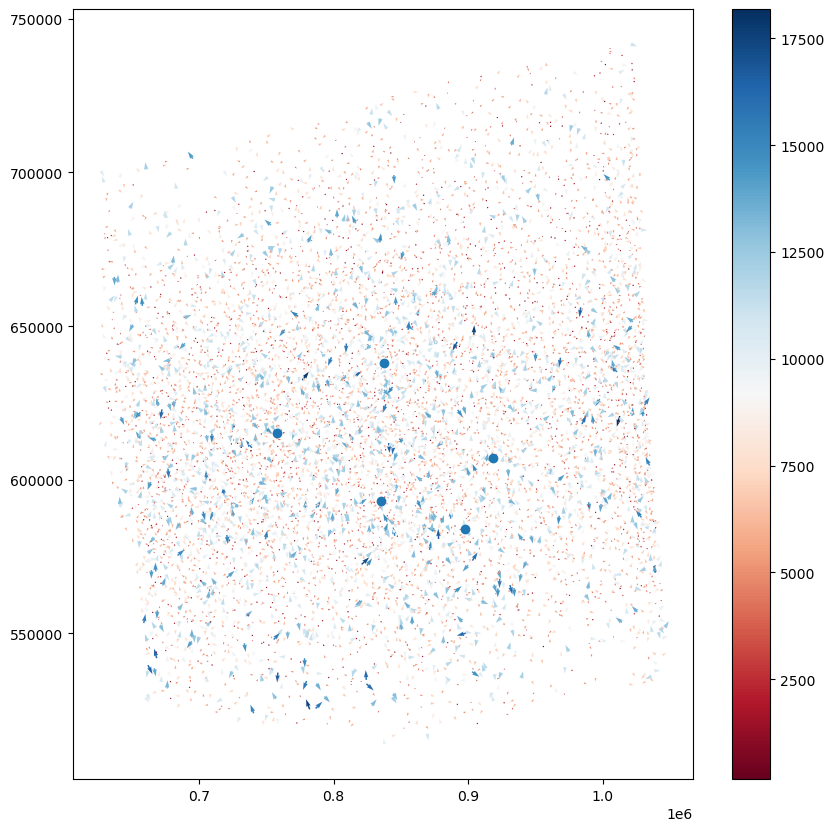

In [444]:
# vector plot for nucleus points "snap" residuals
plt.rcParams['figure.figsize'] = [10, 10]

axes = [0, 1]

d_ = numpy.linalg.norm(snap_residuals[:, axes], axis=1)
fig, ax = plt.subplots()
ax.quiver(all_roi_em_final_pts_nms[:, axes[0]], all_roi_em_final_pts_nms[:, axes[1]], snap_residuals[:, axes[0]], snap_residuals[:, axes[1]], d_ , cmap="RdBu")

ax.scatter(disagreement_points[:, axes[0]], disagreement_points[:, axes[1]])

ax.figure.colorbar(sm)

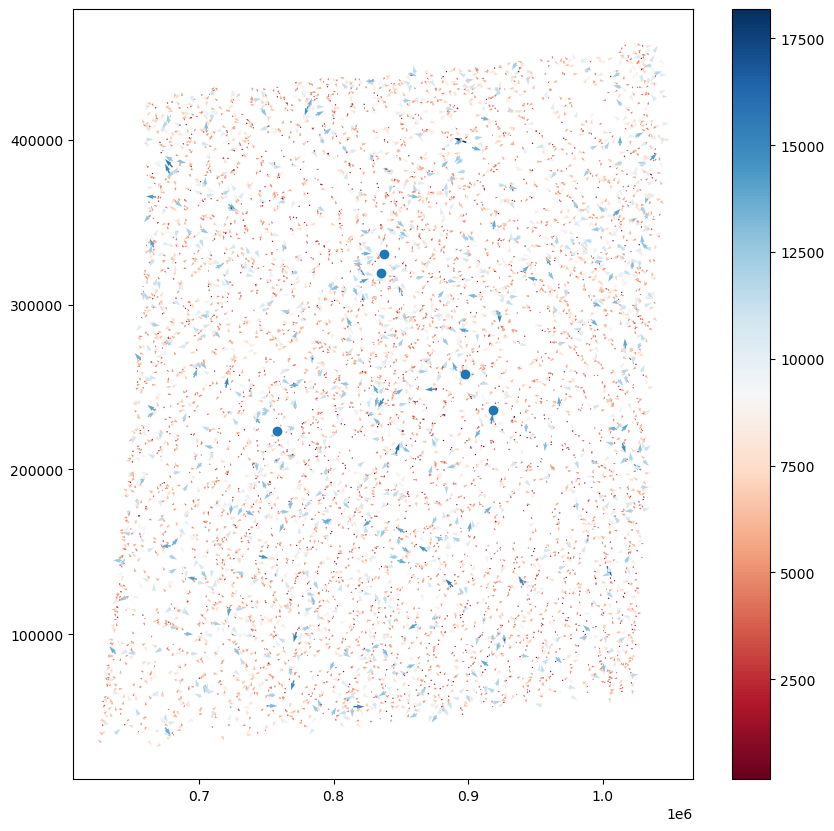

In [445]:
# vector plot for nucleus points "snap" residuals
plt.rcParams['figure.figsize'] = [10, 10]

axes = [0, 2]

d_ = numpy.linalg.norm(snap_residuals[:, axes], axis=1)
fig, ax = plt.subplots()
ax.quiver(all_roi_em_final_pts_nms[:, axes[0]], all_roi_em_final_pts_nms[:, axes[1]], snap_residuals[:, axes[0]], snap_residuals[:, axes[1]], d_ , cmap="RdBu")

ax.scatter(disagreement_points[:, axes[0]], disagreement_points[:, axes[1]])


ax.figure.colorbar(sm)

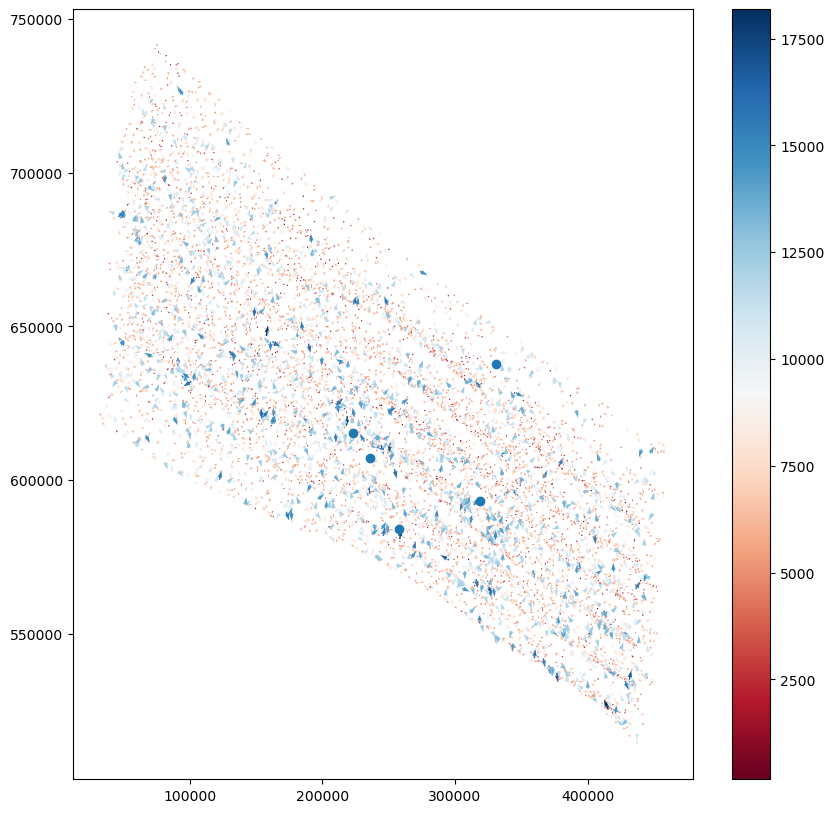

In [446]:
# vector plot for nucleus points "snap" residuals
plt.rcParams['figure.figsize'] = [10, 10]

axes = [2, 1]

d_ = numpy.linalg.norm(snap_residuals[:, axes], axis=1)
fig, ax = plt.subplots()
ax.quiver(all_roi_em_final_pts_nms[:, axes[0]], all_roi_em_final_pts_nms[:, axes[1]], snap_residuals[:, axes[0]], snap_residuals[:, axes[1]], d_ , cmap="RdBu")

ax.scatter(disagreement_points[:, axes[0]], disagreement_points[:, axes[1]])


ax.figure.colorbar(sm)